In [1]:
from lib.pipeline import Pipeline
from lib.ElastixManager import calculate_elastix_transformation,create_downsampled_transforms
import matplotlib.pyplot as plt
from utilities.utilities_registration import (
    register_simple,
    parameters_to_rigid_transform,
    rigid_transform_to_parmeters,
)
from scipy.ndimage import affine_transform
import tifffile as tiff
import os
import numpy as np
import copy

In [21]:
class ManualAligner(Pipeline):
    
    def __init__(self,animal,moving_index):
        super().__init__(animal)
        sectioni = moving_index
        self.moving_index = moving_index
        self.fixed_index = moving_index-1
        INPUT = self.fileLocationManager.get_thumbnail_cleaned(self.channel)
        self.moving_file = os.path.join(INPUT,f'{moving_index:3d}.tif')
        self.fixed_file = os.path.join(INPUT,f'{self.fixed_index:3d}.tif')
        self.moving = tiff.imread(self.moving_file)
        self.fixed = tiff.imread(self.fixed_file)
        self.sections = self.sqlController.get_sections(self.animal, self.channel)
        self.transformation_to_previous_sec = self.get_transformation_to_previous_section()
        self.midpoint = len(self.sections) // 2
        self.center = self.get_rotation_center()
        
    def transform_image(self,img,T):
        matrix = T[:2,:2]
        offset = T[:2,2]
        offset = np.flip(offset)
        img = affine_transform(img,matrix.T,offset)
        return img
    
    def evalulate_transformation(self,img1,img2,T1,T2):
        img1 = self.transform_image(img1,T1)
        img2 = self.transform_image(img2,T2)
        self.compare_two_image(img1,img2)
        
    def compare_two_image(self,img1,img2):
        img1,img2 = img1.astype(float),img2.astype(float)
        vmin_max1 = img1[img1!=0].min(),img1[img1!=0].max()
        vmin_max2 = img2[img2!=0].min(),img2[img2!=0].max()
        img1[img1<2000]=np.nan
        img2[img2<2000]=np.nan
        plt.figure(figsize=[15,15])
        plt.imshow(img1,cmap='Blues',vmin=vmin_max1[0], vmax=vmin_max1[1]*0.8)
        plt.imshow(img2,alpha=0.5,cmap='Reds',vmin=vmin_max2[0], vmax=vmin_max2[1]*0.8)

    def get_transformation_to_previous_section(self):
        transformation_to_previous_sec = {}
        center = self.get_rotation_center()
        for i in range(1, len(self.sections)):
            rotation, xshift, yshift = self.load_elastix_transformation(self.animal, i)
            T = self.parameters_to_rigid_transform(rotation, xshift, yshift, center)
            transformation_to_previous_sec[i] = T
        return transformation_to_previous_sec

    def get_transformation_of_sectioni_to_midpoint(self,sectioni,transformations):
        filename = str(sectioni).zfill(3) + ".tif"
        if sectioni == self.midpoint:
            transformation = np.eye(3)
        elif sectioni < self.midpoint:
            T_composed = np.eye(3)
            for i in range(self.midpoint, sectioni, -1):
                T_composed = np.dot(np.linalg.inv(transformations[i]), T_composed)
            transformation = T_composed
        else:
            T_composed = np.eye(3)
            for i in range(self.midpoint + 1, sectioni + 1):
                T_composed = np.dot(transformations[i], T_composed)
            transformation = T_composed
        return transformation

    def get_transformation_of_sectioni(self,sectioni):
        transformation = self.get_transformation_of_sectioni_to_midpoint(sectioni,self.transformation_to_previous_sec)
        return transformation

    def get_modified_transformation_of_sectioni(self,sectioni,rotation, xshift, yshift):
        T = parameters_to_rigid_transform(rotation, xshift, yshift, self.center)
        transformation_to_previous_sec = copy.copy(self.transformation_to_previous_sec)
        transformation_to_previous_sec[sectioni+1] = T
        transformation = self.get_transformation_of_sectioni_to_midpoint(sectioni,transformation_to_previous_sec)
        return transformation
    
    def compare_untransformed(self):
        self.compare_two_image(self.moving,self.fixed)
        
    # def get_current_transformation_parameters(self):
    #     T = self.transformation_to_previous_sec[self.moving_index]
    #     return rigid_transform_to_parmeters(T,self.center)
    
    def evaluate_current_transformation(self):
        T1 = self.get_transformation_of_sectioni(self.moving_index)
        T2 = self.get_transformation_of_sectioni(self.fixed_index)
        self.evalulate_transformation(self.moving,self.fixed,T1,T2)
        plt.title(self.moving_index);

In [51]:
aligner = ManualAligner('DK78',158)

Check programs took 0.0 seconds


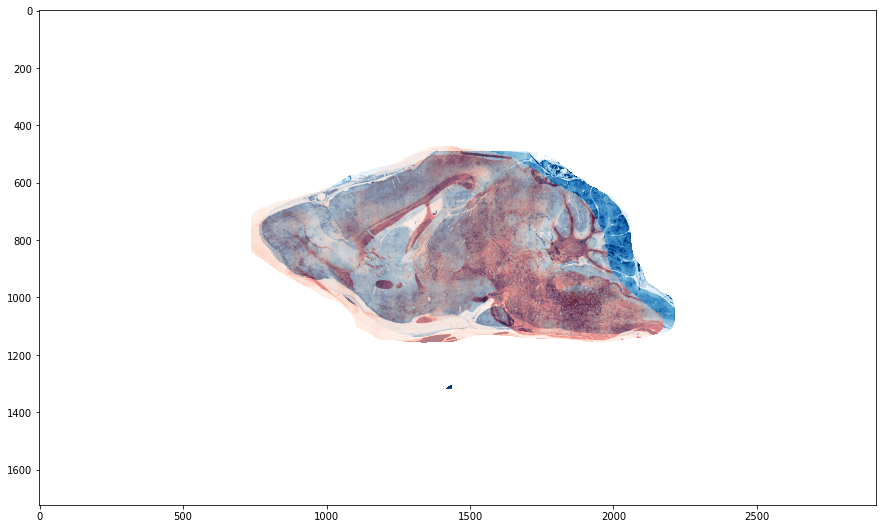

In [52]:
aligner.compare_untransformed()

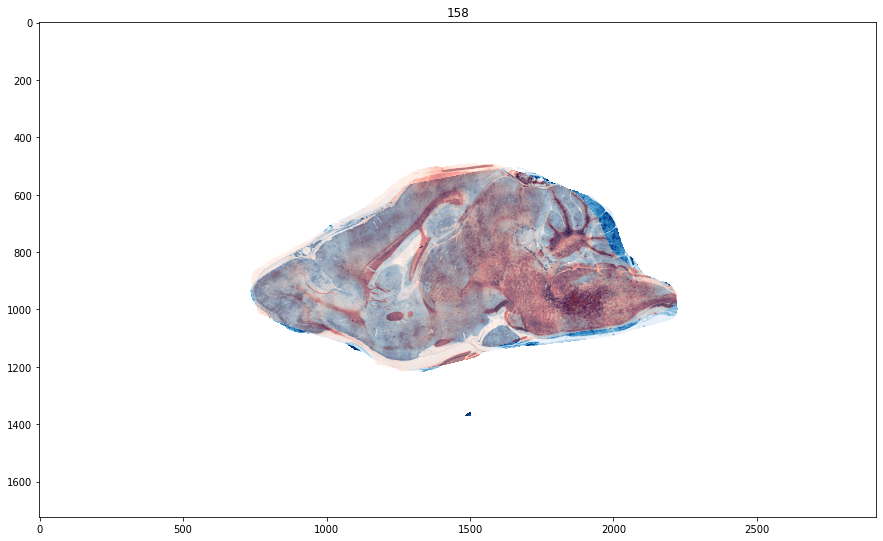

In [53]:
aligner.evaluate_current_transformation()

In [54]:
rotation, xshift, yshift = aligner.load_elastix_transformation(aligner.animal, aligner.moving_index)
print(f'rotation = {rotation}')
print(f'xshift = {xshift}')
print(f'yshift = {yshift}')

rotation = -0.0267553
xshift = 38.3318
yshift = -30.9336


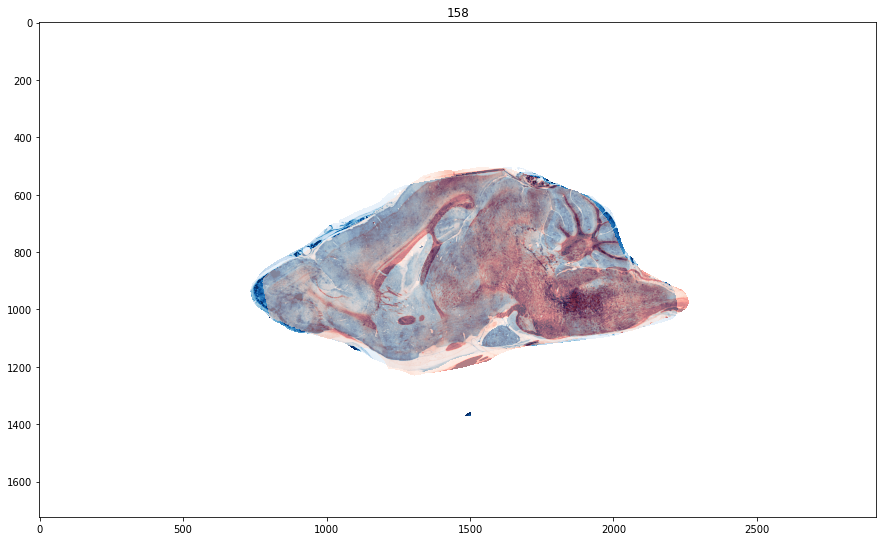

In [59]:
# rotation=-0.1
xshift = 75
yshift= -10
T1 = aligner.get_transformation_of_sectioni(aligner.moving_index)
T2 = aligner.get_transformation_of_sectioni(aligner.fixed_index)
T2 = aligner.get_modified_transformation_of_sectioni(aligner.fixed_index,rotation, xshift, yshift)
aligner.evalulate_transformation(aligner.moving,aligner.fixed,T1,T2)
plt.title(aligner.moving_index);

In [60]:
aligner.sqlController.delete_elastix_row(aligner.animal, aligner.moving_index)
aligner.sqlController.add_elastix_row(aligner.animal, aligner.moving_index, rotation, xshift, yshift)
print('row updated')